# Guide

This is simply guide for excuting this repository. Also contain reqired processing step.

## 0. Make Environment

This fork version is setted as custom data should be located at `Computer_Vision_Project/Dataset` folder.
So unzip original dataset file, and locate this place. And rename the origianl `train.json` file to `old_train.json`. This file is needed to generate new training configs.

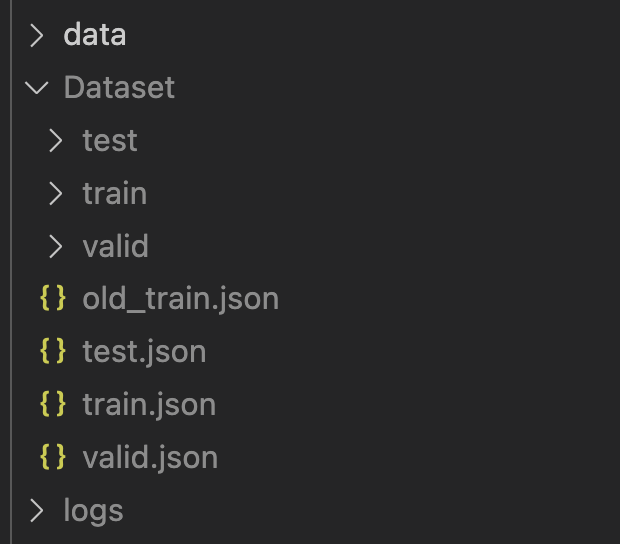

This repository use `poetry`, which is a python package manager.  
To setup python environment process is explained in deatail at `README.md`.  
After that, excute below cells.

## 1. Import config file

In [1]:
import json

# path = "Dataset/old_train.json"
path = "Dataset/new_train.json"
# path = "Dataset/train_augmented.json"
config = json.load(open(path))

### Simple information

Config json has `images` and `annotations` keys.  
Each `images` elements has `id`, `width`, `height` and `file_name` keys.  
Each `annotations` elements has `id`, `image_id`, `category_id`, `segmentation`, `area`, `bbox` and `iscrowd`.  
`id` and `image_id` labels are the same in this file, and `iscrowd` is not used.  
`bbox` annotation contains 4 numbers, which is (`left_upper_x`, `left_upper_y`, `bbox_width`, `bbox_height`).

Whole dataset have 4 scenery. Each scenery is divided by iamge number. For 0~123, 124~236, 237~331, 332~457.  
Also, 6, 21, 35, 41, 74 is weired train image.

In [2]:
annotated_idx = []
for ele in config["annotations"]:
    annotated_idx.append(ele["image_id"])
    
# number of images for whole dataset
print(len(set(annotated_idx)))

# number of images for each sceneries
categories = {x:[] for x in range(5)}
for num in set(annotated_idx):
    if num < 124:
        if num not in [6, 21, 35, 41, 74]:
            categories[0].append(num)
    elif num < 237:
        categories[1].append(num)
    elif num < 332:
        if num not in [241, 254, 256]:
            categories[2].append(num)
    elif num < 457:
        categories[3].append(num)
    else:
        categories[4].append(num)

for cat in categories:
    print(len(categories[cat]))

val_num = [6, 6, 4, 6, 22]
# val_num = [12, 12, 9, 12, 11]
print(sum(len(categories[cat]) for cat in categories))
# 12 12 9 12 11

456
119
112
92
125
0
448


In [3]:
# extract random number for valid
import random
random.seed(0)
valid_idx = []

# extract about 10% images for each sceneries
valid_idx += random.sample(categories[0], val_num[0])
valid_idx += random.sample(categories[1], val_num[1])
valid_idx += random.sample(categories[2], val_num[2])
valid_idx += random.sample(categories[3], val_num[3])
if categories[4]:
    valid_idx += random.sample(categories[4], val_num[4])

len(valid_idx)
# valid_idx

22

In [4]:
# iamges size, all the same
set([(ele["height"], ele["width"]) for ele in config["images"]])

{(345, 640)}

### Make new train/valid config

In [5]:
import matplotlib.pyplot as plt
import cv2

train = {"images": [], "annotations": [], "classes": [x for x in range(15)]}
# no validation
for idx in set(annotated_idx):
# for idx in (set(annotated_idx)-set(valid_idx)):
    train["images"].append(config["images"][idx])
    # img = cv2.imread("Dataset/" + config["images"][idx]["file_name"])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # break
    
for ann in config["annotations"]:
    # if ann["image_id"] in (set(annotated_idx)-set(valid_idx)):
    if ann["image_id"] in set(annotated_idx):
        new_ann = ann.copy()
        new_ann["category_id"] = ann["category_id"] - 1
        x, y, w, h = ann["bbox"]
        x /= 640
        y /= 345
        w /= 640
        h /= 345
        new_ann["bbox"] = (x + w/2, y + h/2, w, h)
        train["annotations"].append(new_ann)
        # cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)
        # plt.imshow(img)
    # break

with open("Dataset/train.json", "w") as f:
    json.dump(train, f, indent=4)

In [6]:
len(train["images"]), len(train["annotations"])

(456, 2125)

In [7]:
valid = {"images": [], "annotations": [], "classes": [x for x in range(15)]}
print(valid_idx)
for idx in valid_idx:
    valid["images"].append(config["images"][idx])
for ann in config["annotations"]:
    if ann["image_id"] in valid_idx:
        new_ann = ann.copy()
        new_ann["category_id"] = ann["category_id"] - 1
        x, y, w, h = ann["bbox"]
        x /= 640
        y /= 345
        w /= 640
        h /= 345
        new_ann["bbox"] = (x + w/2, y + h/2, w, h)
        valid["annotations"].append(new_ann)
with open("Dataset/valid.json", "w") as f:
    json.dump(valid, f, indent=4)
        
len(valid["images"]), len(valid["annotations"])

[113, 53, 102, 118, 57, 5, 157, 189, 186, 175, 225, 231, 278, 301, 285, 314, 446, 448, 359, 396, 349, 368]


(22, 101)

### Plot validation annotations

278
0.771875 0.6391304347826088 0.284375 0.7159420289855073
0.33281249999999996 0.6159420289855072 0.271875 0.7623188405797101
0.37343750000000003 0.3826086956521739 0.096875 0.3536231884057971
0.96015625 0.5971014492753624 0.0765625 0.6956521739130435
0.65625 0.5173913043478261 0.08125 0.3333333333333333


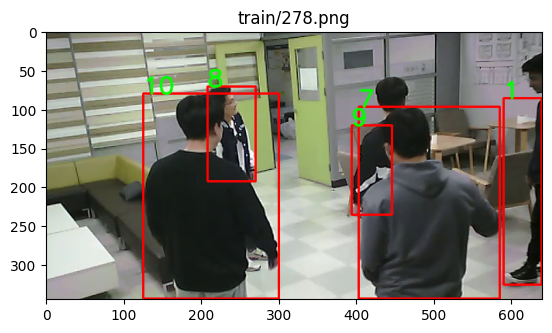

In [20]:
for ele in valid["images"][-10:]:
    img = cv2.imread("Dataset/" + ele["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    id = ele["id"]
    print(id)
    for ann in valid["annotations"]:
        if ann["image_id"] == id:
            c = ann["category_id"]+1
            x, y, w, h = ann["bbox"]
            print(x, y, w, h)
            x -= w/2
            y -= h/2
            x *= 640
            y *= 345
            w *= 640
            h *= 345
            cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)
            cv2.putText(img, str(c), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    plt.imshow(img)
    plt.title(ele["file_name"])
    plt.show()
    break

In [24]:
valid_idx

[113,
 53,
 102,
 118,
 57,
 5,
 157,
 189,
 186,
 175,
 225,
 231,
 278,
 301,
 285,
 314,
 446,
 448,
 359,
 396,
 349,
 368]

430
113.084 89.331 72.598 163.093
335.702 5.146 61.213 183.773
263.04 24.043 75.886 138.263
244.983 120.527 117.361 226.789
506.028 65.604 84.526 153.404


Text(0.5, 1.0, '430.png')

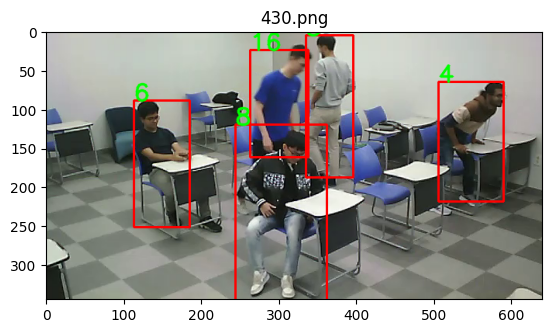

In [9]:
id = 430

img = cv2.imread(f"Dataset/train/{id}.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(id)
for ann in config["annotations"]:
    if ann["image_id"] == id:
        c = ann["category_id"]+1
        x, y, w, h = ann["bbox"]
        print(x, y, w, h)
        cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)
        cv2.putText(img, str(c), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
plt.imshow(img)
plt.title(f"{id}.png")

After make new configs, than you can start training. Here's my training commands, and this requires `darknet53.conv.74` pretrained weight file.  
Download pretrained weight is explained in `README.md`

* Training command 
    ```
    poetry run yolo-train --epochs 500 --model config/yolov3-custom.cfg --train Dataset/train.json --valid Dataset/valid.json --pretrained weights/darknet53.conv.74
    ```
* Inference by bbox images
    ```
    poetry run yolo-detect --model config/yolov3-custom.cfg --weights checkpoints/yolov3_ckpt_{your_version}.pth --config Dataset/valid.json
    ```

* Print detailed metrics
    ```
    poetry run yolo-test --model config/yolov3-custom.cfg --weights checkpoints/yolov3_ckpt_{your_version}.pth --config Dataset/valid.json
    ```
* Generate submit json file
    * This code was hasten, you need manually change `load_model` part with yout trained `.pth` file path.
    ```
    python infer.py
    ```

## A. Plot infer result

462
(345, 640, 3)
8 133 87 94 255
5 1 121 94 221


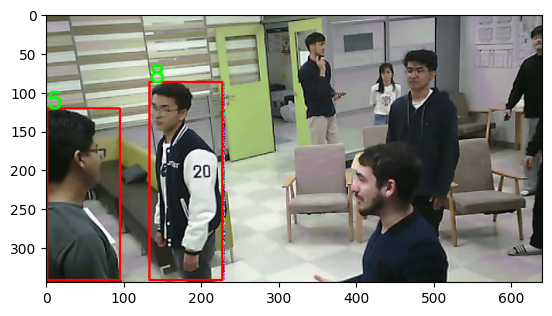

In [10]:
import json
from PIL import Image
import matplotlib.pyplot as plt
import cv2

with open("Dataset/train_augmented.json", "r") as f:
    data = json.load(f)

new_pred = []
for idx in range(457):
    # idx = 462
    print(idx)
    img = cv2.cvtColor(cv2.imread(f"Dataset/train/{idx}.png"), cv2.COLOR_BGR2RGB)
    print(img.shape)
    for ele in data["annotations"]:
        if ele["image_id"] == idx:
            new_pred.append(ele)
            x1, y1, w, h = ele["bbox"]
            x1, y1, w, h = map(round, (x1, y1, w, h))
            cat = ele["category_id"]
            print(cat, x1, y1, w, h)
            img = cv2.rectangle(img, (x1, y1), (x1+w, y1+h), (255, 0, 0), 2)
            cv2.putText(img, str(cat), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    plt.imshow(img)
    plt.show()
    
# with open("new_train.json", "w") as f:
#     json.dump(new_pred, f, indent=4)

## B. Make Pseudo Labeling

In [5]:
import json
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np

import torch
import zipfile

from pytorchyolo.models import load_model
from pytorchyolo.utils.utils import non_max_suppression, rescale_boxes
from pytorchyolo.detect import _create_data_loader
import json
from pathlib import Path

model = load_model("config/yolov3-custom.cfg", "checkpoints/yolov3_ckpt_500.pth").cuda()
model.eval()
images = sorted([str(x) for x in Path("Dataset/train").rglob("*.png")])
dataloader = _create_data_loader(images, 1, model.hyperparams["width"], 8)

config = json.load(open("Dataset/old_train.json"))

pred = {"images": config["images"], "annotations": config["annotations"], "classes": [x for x in range(1, 16)]}

conf_thres = 0.25
# conf_thres = 0.001
nms_thres = 0.4

for (img_paths, input_imgs) in tqdm(dataloader, desc="Detecting"):
    name = img_paths[0].split("/")[-1].split(".")[0]

    if int(name) in set(annotated_idx) or int(name) > 456:
        continue
    # print(name)
    # Get detections
    with torch.no_grad():
        detections = model(input_imgs.cuda())
        detections = non_max_suppression(detections, conf_thres, nms_thres)
        h, w = (345, 640)
        detections = rescale_boxes(detections[0], model.hyperparams["width"], (h, w))
        for x1, y1, x2, y2, conf, cls_pred in detections:
            x1, y1, x2, y2, conf, cls_pred = map(lambda x:x.item(), [x1, y1, x2, y2, conf, cls_pred])
            # y1, y2 = map(lambda y: y/h, [y1, y2])
            # x1, x2 = map(lambda x: x/w, [x1, x2])
            pred["annotations"].append({
                        "annotation_id": len(pred["annotations"]),
                        "image_id": int(name),
                        "category_id": int(cls_pred) + 1,
                        "bbox": list(map(lambda x:float(f"{x:.3f}"), [x1, y1, x2-x1, y2-y1])),
                    })

new_pred = []
for idx in list(set(range(457))-set(annotated_idx)):
    # idx = 0
    print(idx)
    img = cv2.cvtColor(cv2.imread(f"Dataset/train/{idx}.png"), cv2.COLOR_BGR2RGB)
    # print(img.shape)
    for ele in pred:
        if ele["image_id"] == idx:
            new_pred.append(ele)
            x, y, w, h = ele["bbox"]
            cat = ele["category_id"]
            # print(cat, x, y, w, h)
            img = cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)
            cv2.putText(img, str(ele["category_id"]), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    # plt.imshow(img)
    # plt.show()
    
with open("new_train.json", "w") as f:
    json.dump(new_pred, f, indent=4)

Detecting: 100%|██████████| 684/684 [00:11<00:00, 57.16it/s]
